In [280]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage
import math
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage import util 
from scipy import ndimage
from skimage.morphology import reconstruction
from skimage.color import rgb2hed, hed2rgb
from skimage.morphology import disk
from skimage.filters.rank import entropy
from skimage.segmentation import random_walker
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu, rank
from scipy import ndimage as ndi
from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
from skimage import morphology
from skimage import segmentation
from skimage.filters import threshold_otsu, threshold_local, median
from skimage import data, segmentation, feature, future
from skimage.segmentation import random_walker
from skimage.measure import label, regionprops
from skimage.color import rgb2gray
from skimage.morphology import reconstruction
from skimage.filters import unsharp_mask, median
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util, exposure
)
from skimage.morphology import square
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import sobel
from skimage.segmentation import watershed
from skimage.color import rgb2gray
from skimage import (
    data, restoration, util
)

In [2]:
coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f and 'macrophage' in f:
        print(f)
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()
cdf.head()

ND_macrophage_coords.csv
HFD8_macrophage_coords.csv
HFD14_macrophage_coords.csv
cdf.shape=(7424, 4)
HFD8     3394
ND       2036
HFD14    1994
Name: key, dtype: int64



spotId            x            y key
0  AAACAAGTATCTCCCA.1  1263.912793  1164.571691  ND
1  AAACAGCTTTCAGAAG.1   331.221482  1043.233630  ND
2  AAACAGGGTCTATATT.1   371.414081  1112.975138  ND
3  AAACATTTCCCGGATT.1  1213.938136  1356.563577  ND
4  AAACCCGAACGAAATC.1  1394.171280  1077.242752  ND

In [3]:
imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/hires/"

keyMap = {
    '1105-LM-1C' : 'HFD8',
    '1105-LM-1D' : 'HFD14', 
    '1105-LM-1B' : 'ND',
}

imgs = {}

for f in os.listdir(imDir):
    if f.endswith("tif"):
        SPTkey = f.replace(".tif", "")
        if not SPTkey in keyMap.keys():
            continue
        
        fullpath = f"{imDir}{f}"
        img = skimage.io.imread(fullpath, as_gray=True)
        key = keyMap[SPTkey]
        print(key, img.shape)
        imgs[key] = img

print('done')

HFD8 (39147, 33122)
HFD14 (40713, 33149)
ND (39460, 33174)
done


In [4]:
imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/lowres/"


lowres = {}

for f in os.listdir(imDir):
    if f.endswith("png"):
        fullpath = f"{imDir}{f}"
        img = skimage.io.imread(fullpath, as_gray=True)
        key = f.replace(".png", "")
        print(key, img.shape)
        lowres[key] = img

print('done')

HFD14 (2000, 1628)
ND (2000, 1681)
HFD8 (2000, 1692)
done


In [292]:
def getWindow(img, winSize=2000, center=None):
    """A function to get a cropped image"""
    
    if center is None:
        centerX = img.shape[0] // 2
        centerY = img.shape[1] // 2
    else:
        centerX = center[0]
        centerY = center[1]
        
    xmin = centerX - (winSize // 2)
    xmax = centerX + (winSize // 2)
    
    ymin = centerY - (winSize // 2)
    ymax = centerY + (winSize // 2)
    return img[xmin:xmax, ymin:ymax]


def plot_process(image, n_image, cells):
    fig, axs = plt.subplots(nrows=1, ncols=3)
    axs = axs.ravel()
    
    axs[0].imshow(image, cmap='gray')
    axs[0].axis(False)
    axs[0].set_title("Raw Image")

    axs[1].imshow(n_image, cmap='gray')
    axs[1].axis(False)
    axs[1].set_title("Processed Image")

    axs[2].imshow(color.label2rgb(cells))
    axs[2].axis(False)
    axs[2].set_title("Segmented Image")
    
    
def getFeatures(cells, returnProps=False):
    """A function to return a dataframe of features from the cells"""
    
    new_rows = []
    props = regionprops(cells)

    for region in regionprops(cells):
        
        if region.perimeter > 0:
            circularity = 4* math.pi * (region.area / region.perimeter**2)
        else: 
            circularity = 0
        
        row = {
            'area' : region.area,
            'area_convex' : region.area_convex,
            'area_filled' : region.area_filled,
            'axis_major_length' : region.axis_major_length,
            'axis_minor_length' : region.axis_minor_length, 
            'centroid' : region.centroid,
            'eccentricity' : region.eccentricity,
            'equivalent_diameter_area' : region.equivalent_diameter_area,
            'extent' : region.extent,
            'feret_diameter_max' : region.feret_diameter_max,
            'label' : region.label,
            'orientation' : region.orientation,
            'perimeter': region.perimeter,
            'perimeter_crofton': region.perimeter_crofton,
            'solidity': region.solidity,
            'circularity' : circularity,
        }
        
        new_rows.append(row)

    if returnProps:
        return pd.DataFrame(new_rows), props
    else:
        return pd.DataFrame(new_rows)

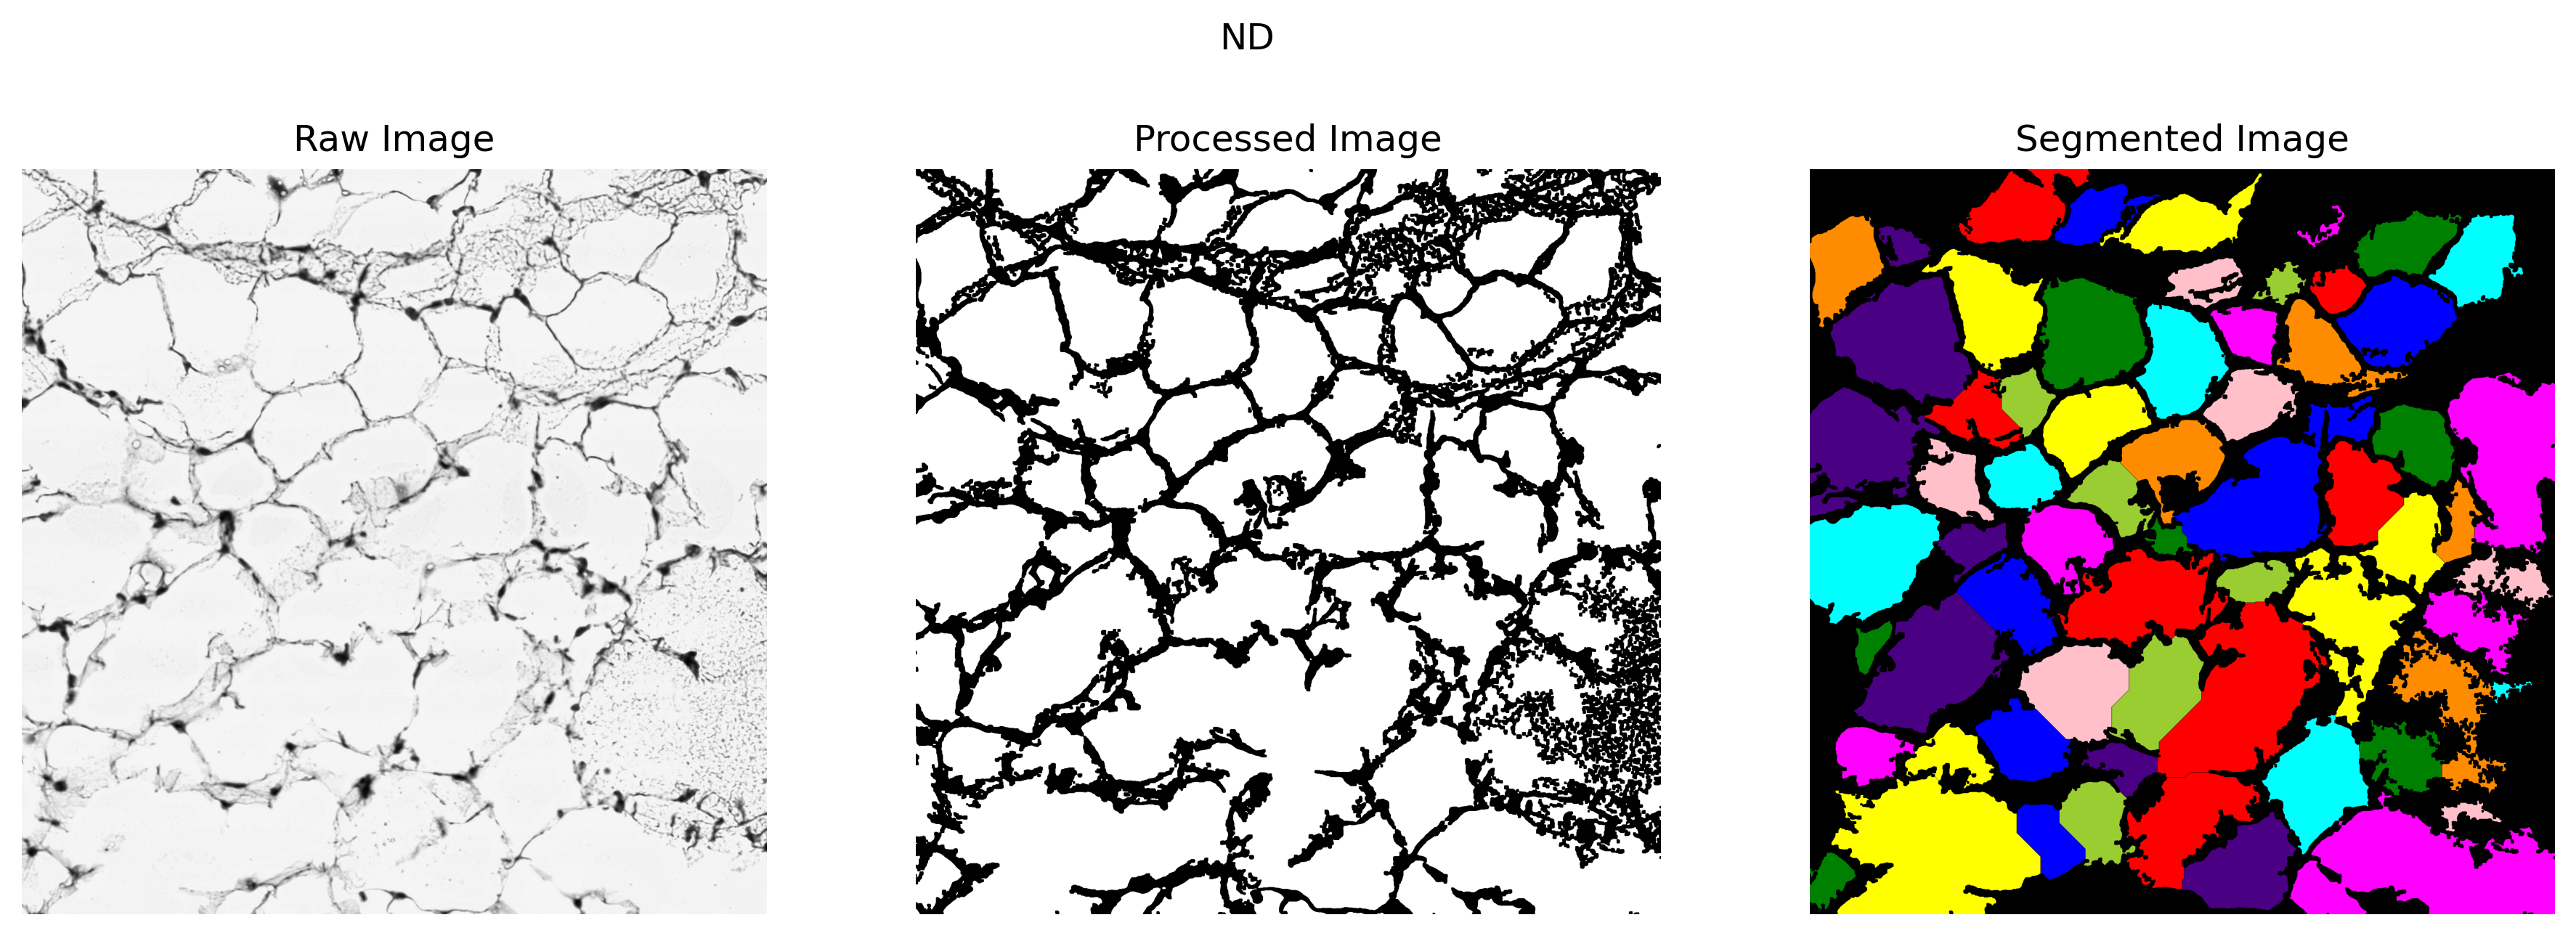

             area  perimeter  circularity
count      66.000     66.000       66.000
mean    37830.000   1255.021        0.319
std     30115.398    652.631        0.160
min      1712.000    435.599        0.039
25%     15526.750    754.593        0.194
50%     31168.500   1097.525        0.295
75%     49291.250   1422.101        0.467
max    141749.000   3391.135        0.688


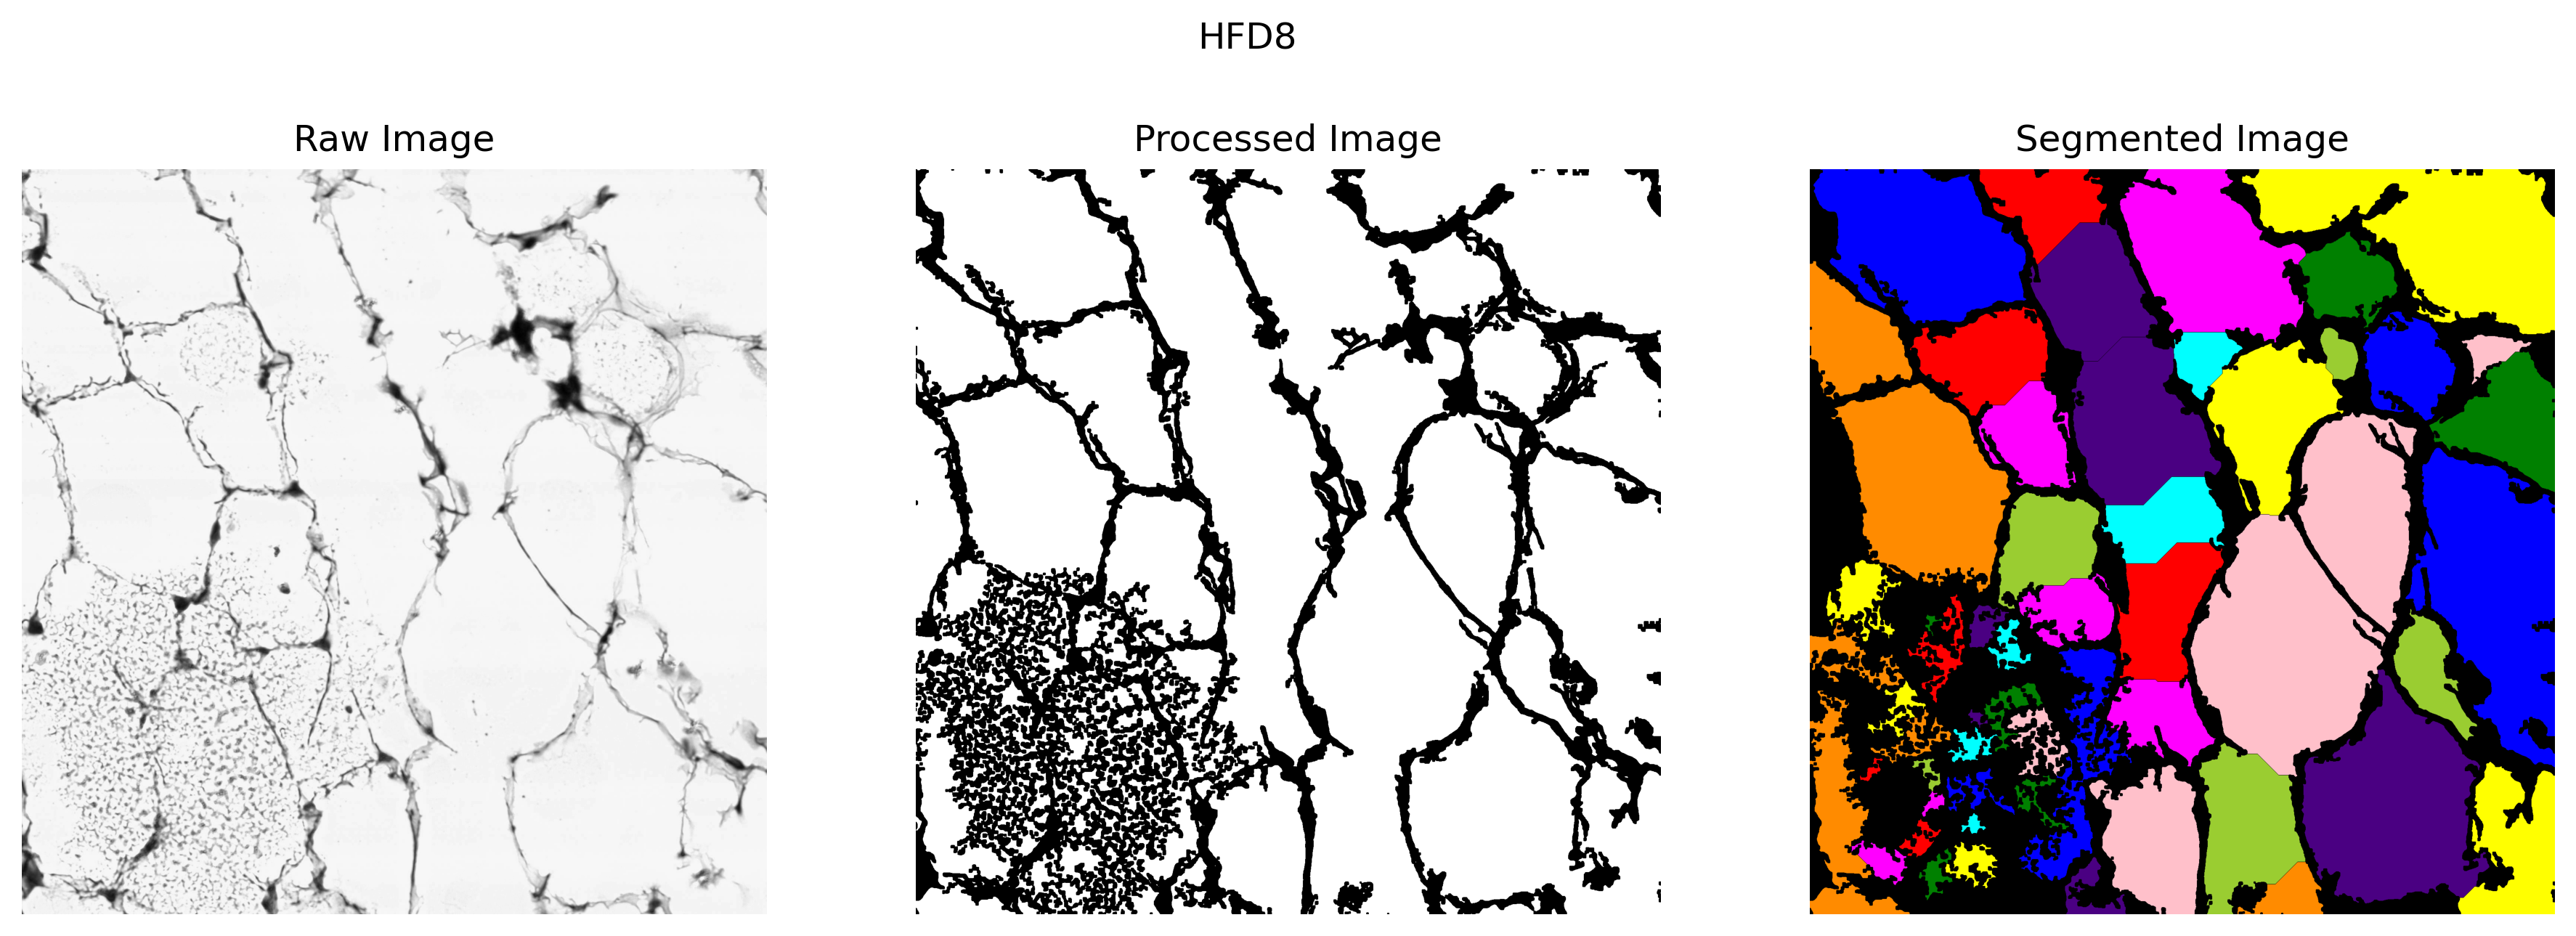

             area  perimeter  circularity
count      57.000     57.000       57.000
mean    50308.807   1477.301        0.240
std     60561.431    858.762        0.160
min       647.000    201.675        0.026
25%      5788.000    806.163        0.094
50%     24003.000   1386.880        0.224
75%     66956.000   1919.689        0.343
max    221650.000   3606.313        0.678


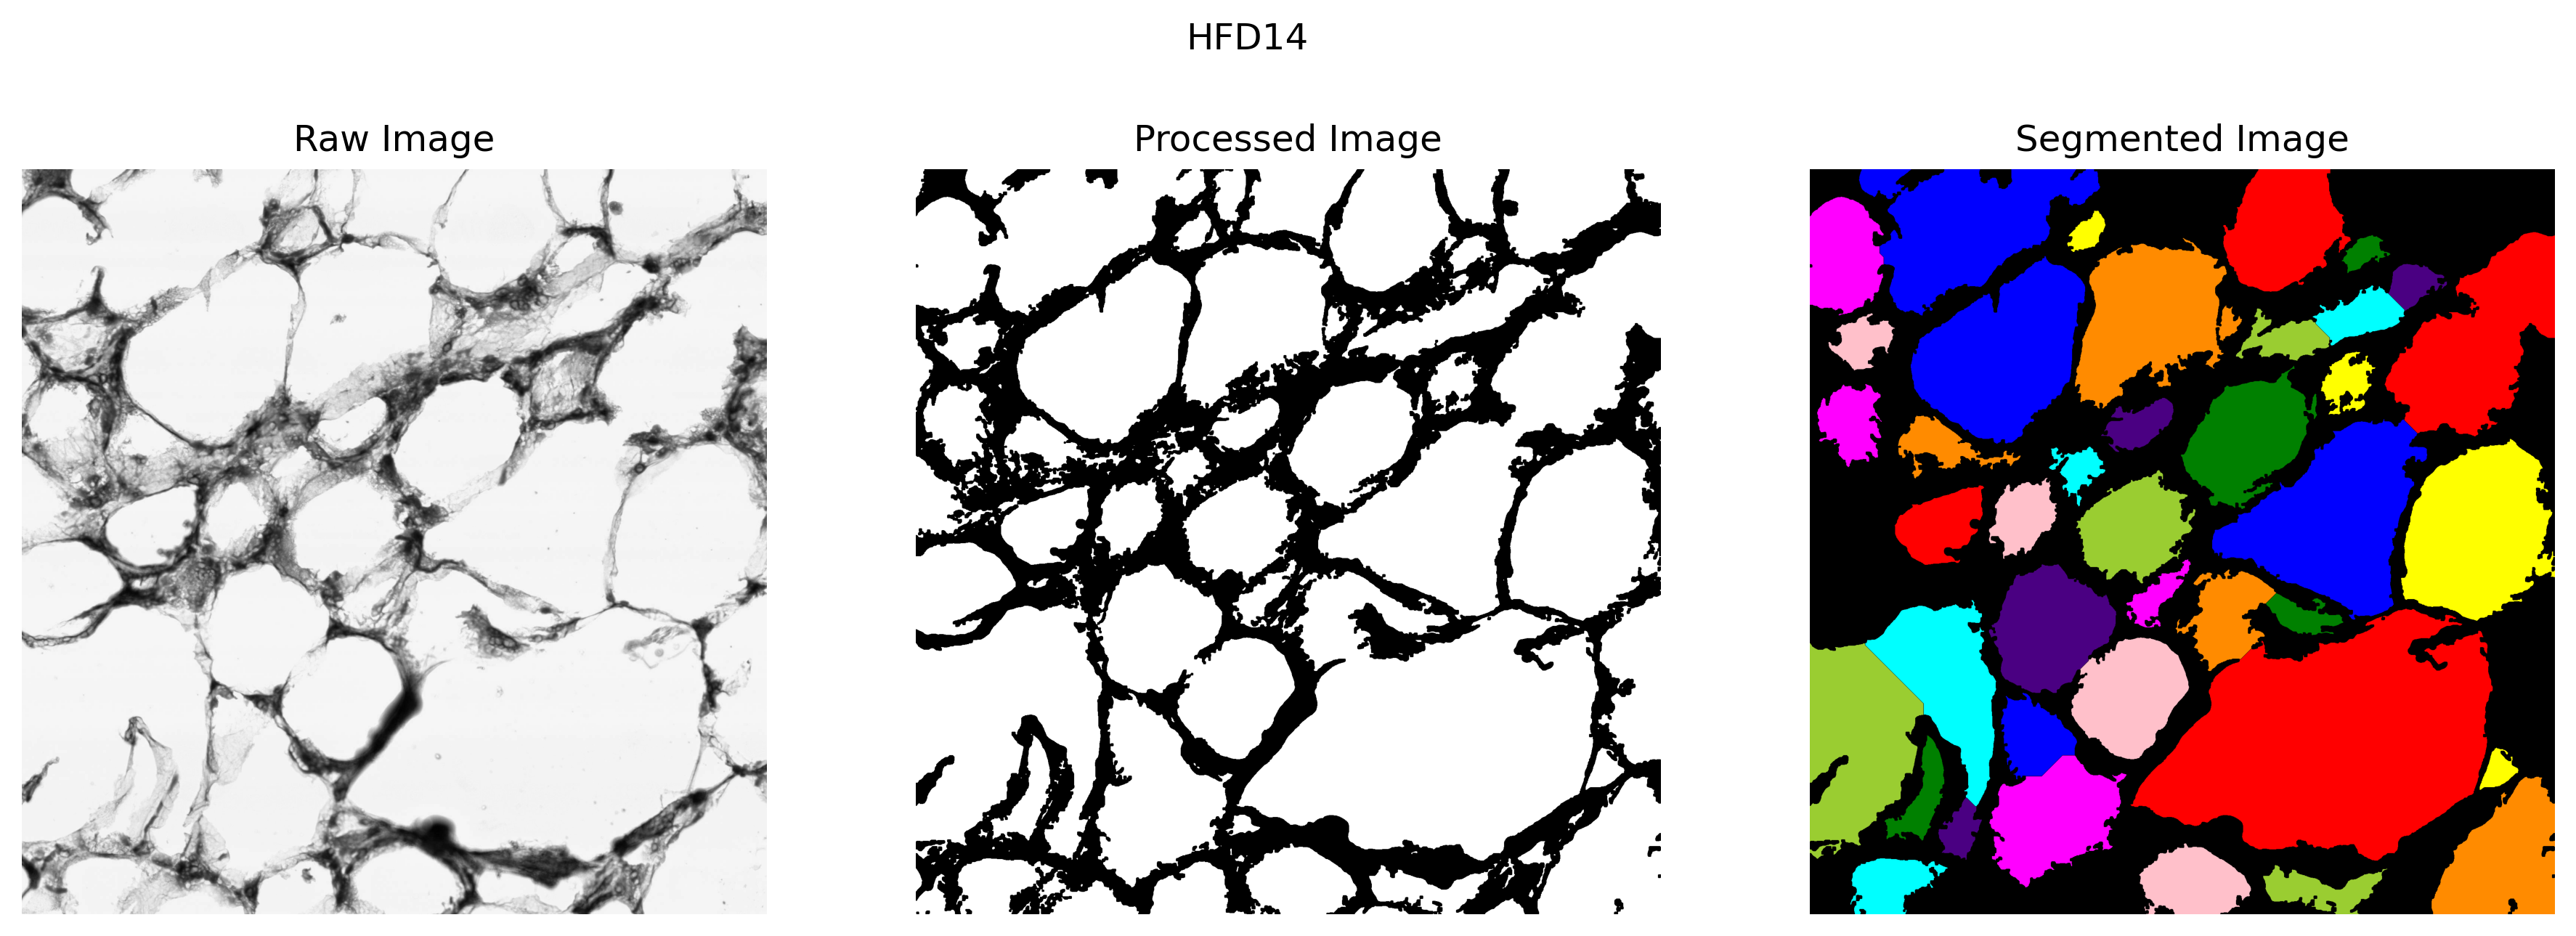

             area  perimeter  circularity
count      40.000     40.000       40.000
mean    61567.450   1344.515        0.346
std     74155.429    739.178        0.125
min      6174.000    395.262        0.116
25%     15103.000    884.770        0.246
50%     30643.000   1063.178        0.340
75%     79566.000   1728.566        0.417
max    415090.000   3930.034        0.596


<Figure size 4500x1500 with 0 Axes>

In [331]:
""" Segement the low definition images """

def segement_image(image, unshrp_rad, sigma,
                   unshrp_amnt, min_peak_dist, 
                   median_fp, erosion_fp, line=True):
    """A function to segement the cells in an image 
    """
    n_image = image.copy()
    
    # sharen the image
    n_image = unsharp_mask(n_image, 
                           radius=unshrp_rad, 
                           amount=unshrp_amnt)

    
    n_image = filters.gaussian(n_image, sigma=sigma)
    
    footprint = morphology.square(erosion_fp)
    n_image = morphology.erosion(n_image, footprint)
        
    footprint = morphology.square(median_fp)
    n_image = filters.median(n_image)
        
     # fill holes
    seed = np.copy(n_image)
    seed[1:-1, 1:-1] = n_image.max()
    mask = n_image
    n_image = reconstruction(seed, mask, method='erosion')

    # threshold new grey values
    n_image = n_image > filters.threshold_otsu(n_image)

    distance = ndi.distance_transform_edt(n_image)
    local_max_coords = feature.peak_local_max(distance, min_distance=min_peak_dist)
    local_max_mask = np.zeros(distance.shape, dtype=bool)
    local_max_mask[tuple(local_max_coords.T)] = True
    labels = measure.label(local_max_mask)

    cells = segmentation.watershed(-distance, 
                                   labels, 
                                   mask=n_image, 
                                   watershed_line=line)
    
    
    
    return n_image, cells



plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 5

size = 2000
    
keys = ['ND', 'HFD8', 'HFD14']
cmap = 'binary'

for key in keys:
    # img = lowres[key]
    img = imgs[key]
    
    # trim the image
    img = getWindow(img, size)   
    
    # fig, ax = try_all_threshold(img, verbose=True);
    
    # img = util.invert(img)
    n_image, cells = segement_image(img, 
                                    unshrp_rad=50, 
                                    unshrp_amnt=100,
                                    sigma=1,
                                    median_fp=5, 
                                    erosion_fp=6, 
                                    min_peak_dist=65)
    
    plot_process(img, n_image, cells)
    plt.suptitle(key)
    plt.show()
    rf = getFeatures(cells)
    
    print(rf[['area', 'perimeter', 'circularity']].describe().round(3))
    
plt.tight_layout()

In [ ]:
break

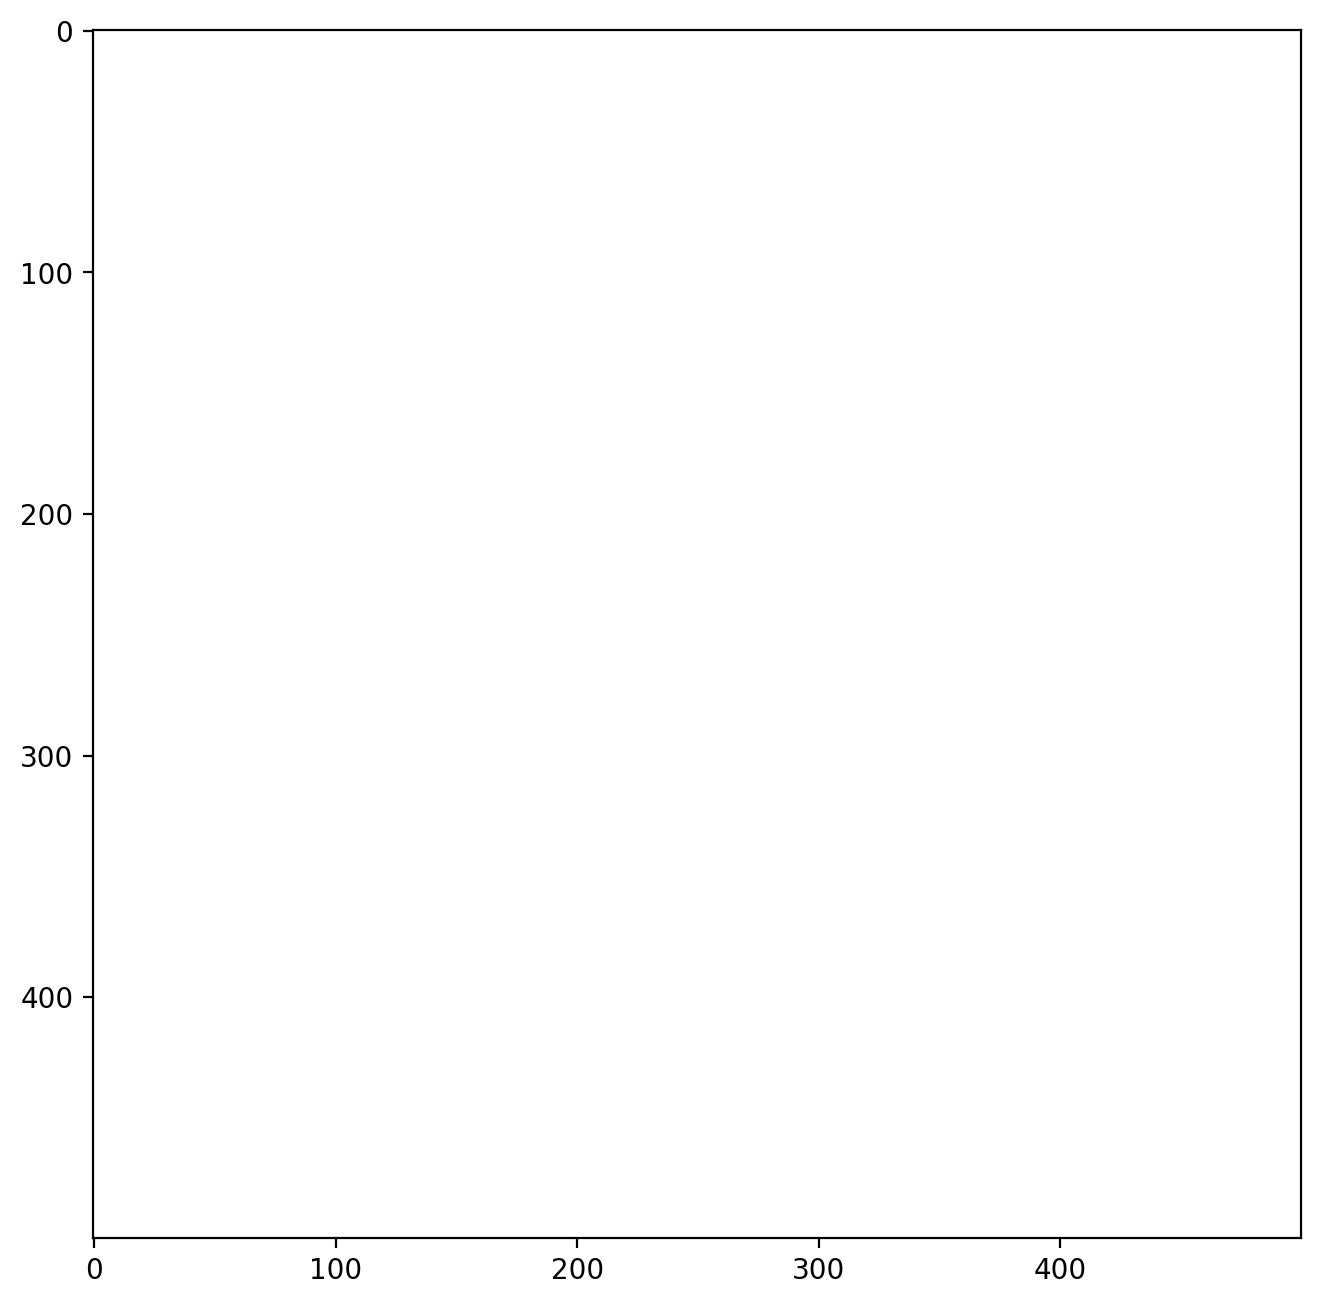

In [285]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 8

def plot_cell(ax, points, color='green', lw=0.5):
    if len(points) > 3:
        try:
            hull = ConvexHull(points)
            ax.plot(points[hull.vertices, 1], points[hull.vertices, 0], color=color, lw=lw, zorder=1)
            ax.fill(points[hull.vertices, 1], points[hull.vertices, 0], color=color, alpha=0.4, zorder=1)
        except:
            pass
        
        
"""
TODO: remove edges
"""

A = np.ones((res.shape))

fill_pass = [(df['circularity'] > 0.1) & (df['circularity'] < 1)][0]
df['INCLUDE'] = np.where(fill_pass, 1, 0)

plt.imshow(A, cmap='binary', zorder=0)    
ax = plt.gca()

for idx, row in df.iterrows():
    
    pts = props[idx].coords
    
    if fill_pass[idx]:
        plot_cell(ax, pts)
    else:
        plot_cell(ax, pts, color='red', lw=1)

plt.imshow(A, cmap='binary')   

In [ ]:
break

In [ ]:
imgs.keys()

In [ ]:
# "downscale the hires images"

# def tyler(img, n, m):
#     """A function to split an array into tiles """
#     return [img[x:x+m,y:y+n] for x in range(0,img.shape[0],m) for y in range(0,img.shape[1],n)]

# keys = ['ND', 'HFD8', 'HFD14']

# fig, axs = plt.subplots(4, 4)
# axs = axs.ravel()

# for key in keys:
#     img = imgs[key]  
#     print(img.shape)
    
#     t = tyler(img, 10000, 10000)
    
#     for i, subimg in enumerate(t):
#         axs[i].imshow(subimg)
#     # downscaled = rescale(img, scaleFactor, anti_aliasing=True)
#     # print(img.shape, downscaled.shape)
#     # plt.imshow(downscaled, cmap='binary')
#     break
    
# plt.tight_layout()

In [ ]:
def getWindow(img, winSize=2000, center=None):
    """A function to get a cropped image"""
    
    if center is None:
        centerX = img.shape[0] // 2
        centerY = img.shape[1] // 2
    else:
        centerX = center[0]
        centerY = center[1]
        
    xmin = centerX - (winSize // 2)
    xmax = centerX + (winSize // 2)
    
    ymin = centerY - (winSize // 2)
    ymax = centerY + (winSize // 2)
    return img[xmin:xmax, ymin:ymax]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['figure.facecolor'] = "w"

keys = ['HFD14']
cmap = 'gist_earth'
winSize = 1500
radius = 50
diskSize = 1

fig, axs = plt.subplots(1, 4)
axs = axs.ravel()

for key in keys:
    coord = cdf[cdf['key'] == key]
    img = imgs[key]
    imgLR = lowres[key]
    
    randSpot = coord.sample(1)
    x = randSpot['x'].values[0]
    y = randSpot['y'].values[0]
    
    newX = (x * img.shape[1]) / imgLR.shape[1]
    newY = (y * img.shape[0]) / imgLR.shape[0]
    
    rawWin = getWindow(img, winSize, center=[int(newY), int(newX)])

    axs[0].imshow(imgLR, cmap=cmap)
    axs[0].scatter(randSpot['x'], 
                   randSpot['y'], 
                   marker="s", 
                   edgecolor="r", 
                   facecolor='None',
                   s=np.sqrt(winSize),
                   lw=1)

    axs[0].set_xticks([])
    axs[0].set_yticks([])

    axs[1].imshow(rawWin, cmap=cmap)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    """Image processing """
    background = restoration.rolling_ball(rawWin, radius=radius)
    win = rawWin - background
    ent = entropy(win, disk(diskSize))
    
    axs[2].imshow(ent, cmap=cmap)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    
    """THRESHOLDING"""
    thresh = threshold_otsu(ent)
    binary = ent > thresh
    binary = median(binary, np.ones((5, 5)))
    
    # block_size = 11 
    # binary = threshold_local(ent, block_size, offset=1)
    
    axs[3].imshow(binary, cmap='binary')
    axs[3].set_xticks([])
    axs[3].set_yticks([])
    
    percSurface = np.sum(binary) / np.size(binary)
    meanEntropy = ent.mean()
    maxEntropy = ent.max()
    print(f"{percSurface=:.4f} {meanEntropy=:.4f} {maxEntropy=:.4f}")
    
    plt.tight_layout()
    plt.show()

In [ ]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "macrophage" in f:
        print(f)
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        spt[key] = sdf
    
print('done')

In [ ]:
""" rescale the hires images """

scaleFactor = 0.5
medres = {}

keys = ['ND', 'HFD8', 'HFD14']

for key in keys:
    imgHR = imgs[key]
    img = rescale(imgHR, scaleFactor, anti_aliasing=True)
    
    print(f"{imgHR.shape=} {img.shape=}")
    
    medres[key] = img
    
print('done')

In [ ]:
""" Segement the low definition images """

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 5

trim = {
    'ND' : {'xlim' :  [225, 1500], 'ylim' : [1650, 550]},
    'HFD8' : {'xlim' :  [190, 1350], 'ylim' : [1680, 400]},
    'HFD14' : {'xlim' :  [250, 1400], 'ylim' : [1650, 450]},
}

fig, axs = plt.subplots(1, 2)
axs = axs.ravel()

radius = 50
    
keys = ['ND']
cmap = 'binary_r'

for key in keys:
    img = medres[key]
    
#     img = imgLR.copy()
    
#     img = rescale(imgHR, imgLR.shape,  anti_aliasing=True)
    
#     lims = trim[key]
#     img = img[lims['ylim'][1]:lims['ylim'][0], lims['xlim'][0]:lims['xlim'][1]]
    
# #     background = restoration.rolling_ball(img, radius=100)
# #     img = img - background    
    
    axs[0].imshow(img, cmap=cmap)
    img = unsharp_mask(img, radius=radius, amount=25) 
    print(f"{img.max()=} {img.min()=}")
    
    axs[1].imshow(img, cmap=cmap)
    
#     img = np.where(img > 0.1, 1, 0)
    
#     footprint = morphology.disk(3)
#     res = morphology.black_tophat(img, footprint)
#     img = img - res

    
#     background = restoration.rolling_ball(img, radius=radius)
#     img = img - background    
    
#     footprint = morphology.disk(2)
#     img = morphology.white_tophat(img, footprint)
    
#     footprint = morphology.disk(15)
#     img = morphology.white_tophat(img, footprint)
    
    
#     radius = 100
#     footprint = disk(radius)

#     local_otsu = rank.otsu(img, footprint)
#     threshold_global_otsu = threshold_otsu(img)
#     img = img >= threshold_global_otsu  

    
#     background = restoration.rolling_ball(img, radius=radius)
#     img = img - background    
    

#     block_size = 31
#     local_thresh = threshold_local(img, block_size, offset=1)
#     img = img > local_thresh
    
#     img = filters.median(img)
#     img = hessian(img, 
#                   sigmas=[0.1, 0.5, 1.0], 
#                   beta=1, 
#                   gamma=1)

#     thresh = img > filters.threshold_otsu(img)
#     cells = measure.label(thresh)
    
#     axs[0].imshow(img, cmap=cmap)
#     axs[1].imshow(color.label2rgb(cells))

In [ ]:
break

In [ ]:
def segement_image(image, unshrp_rad=100, unshrp_amnt=100, min_peak_dist=10, 
                   line=True, perc=25, blur=3, erode=5, simple=True):
    """A function to segement the cells in an image 
    
    Params:
        image (np.array): image
        unshrp_rad (int): pixel raduis for unsharp masking 
        unshrp_amnt (int): scaling for unsharp masking
        min_peak_dist (int): minimum peak distance for overlapping objects
        line (bool): if true, draw 1 pixel line separating segemented objects 
        
    Returns:
        res (np.array): the preprocessed image
        cells (np.array): the segemented cells from the processed image
    """

    # unsharp masking for illumination correction
    res = unsharp_mask(image, radius=unshrp_rad, amount=unshrp_amnt)
    res = filters.median(res)

    # fill holes
    seed = np.copy(res)
    seed[1:-1, 1:-1] = res.max()
    mask = res
    res = reconstruction(seed, mask, method='erosion')
    
    res = filters.gaussian(res, sigma=blur)
    # hard threshold
    t = np.percentile(res, perc)
    res = np.where(res < t, 0, 1)
    
    res = morphology.erosion(res, footprint=np.ones((erode, erode)))
    res = filters.median(res)

    thresh = res > filters.threshold_otsu(res)
    cells = measure.label(thresh)
    return res, cells

def plot_process(res, cells):
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 12, 12    
    fig, axs = plt.subplots(nrows=1, ncols=3)
    axs = axs.ravel()
    
    axs[0].imshow(image, cmap='gray')
    axs[0].axis(False)
    axs[0].set_title("Raw Image")

    axs[1].imshow(res, cmap='gray')
    axs[1].axis(False)
    axs[1].set_title("Processed Image")

    axs[2].imshow(color.label2rgb(cells))
    axs[2].axis(False)
    axs[2].set_title("Segmented Image")
    
    
keys = ['ND']

sampleSize = 2
winSize = 7000

for key in keys:
    coord = cdf[cdf['key'] == key]
    imgHR = imgs[key]
    imgLR = lowres[key]
    
    rSpots = coord.sample(sampleSize)
    
    for idx, randSpot in rSpots.iterrows():
        x = randSpot['x']
        y = randSpot['y']
        
        newX = (x * imgHR.shape[1]) / imgLR.shape[1]
        newY = (y * imgHR.shape[0]) / imgLR.shape[0]

        img = getWindow(imgHR, winSize, center=[int(newY), int(newX)])

        res = unsharp_mask(img, radius=1, amount=15) 
        plt.imshow(res, cmap='binary_r')
    
#      # unsharp masking for illumination correction
#     res = unsharp_mask(image, radius=5, amount=10)
#     # res = filters.median(res)

#     # # fill holes
#     # seed = np.copy(res)
#     # seed[1:-1, 1:-1] = res.max()
#     # mask = res
#     # res = reconstruction(seed, mask, method='erosion')
    
#     plt.imshow(res)
    

In [ ]:
break

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['figure.facecolor'] = "w"

keys = ['ND']
cmap = 'gist_earth'
winSize = 1500
radius = 100
diskSize = 1
sampleSize = 2


for key in keys:
    coord = cdf[cdf['key'] == key]
    img = imgs[key]
    imgLR = lowres[key]
    
    rSpots = coord.sample(sampleSize)
    
    for idx, randSpot in rSpots.iterrows():
        
        fig, axs = plt.subplots(1, 3)
        axs = axs.ravel()
    
        x = randSpot['x']
        y = randSpot['y']

        newX = (x * img.shape[1]) / imgLR.shape[1]
        newY = (y * img.shape[0]) / imgLR.shape[0]

        rawWin = getWindow(img, winSize, center=[int(newY), int(newX)])

        axs[0].imshow(imgLR, cmap=cmap)
        axs[0].scatter(randSpot['x'], 
                       randSpot['y'], 
                       marker="s", 
                       edgecolor="r", 
                       facecolor='None',
                       s=np.sqrt(winSize),
                       lw=1)

        axs[0].set_xticks([])
        axs[0].set_yticks([])

        axs[1].imshow(rawWin, cmap=cmap)
        axs[1].set_xticks([])
        axs[1].set_yticks([])

        """Image processing """
        background = restoration.rolling_ball(rawWin, radius=radius)
        win = rawWin - background    
        ent = entropy(win, disk(diskSize))
        print(ent.mean())
        
        axs[2].imshow(win, cmap=cmap)
        axs[2].set_xticks([])
        axs[2].set_yticks([])

        plt.tight_layout()
        plt.show()

In [ ]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams['figure.facecolor'] = "w"

plt.imshow(win, cmap=cmap)
plt.xticks([])
plt.yticks([])

In [ ]:
break

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.facecolor'] = "w"

keyMap = {
    'HFD8' : '1105-LM-1C',
    'HFD14' : '1105-LM-1D', 
    'ND' : '1105-LM-1B',
}

winSize = 200

keys = ['ND', 'HFD8', 'HFD14']

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

def getWindow(img, winSize=2000, center=None):
    """A function to get a cropped image"""
    
    if center is None:
        centerX = img.shape[0] // 2
        centerY = img.shape[1] // 2
    else:
        centerX = center[0]
        centerY = center[2]
        
      
    xmin = centerX - winSize
    xmax = centerX + winSize
    
    ymin = centerY - winSize
    ymax = centerY + winSize
    return img[xmin:xmax, ymin:ymax]
    

for i, k in enumerate(keys):
    key = keyMap[k]
    img = imgs[key]
    
    win = getWindow(img)
    
    axs[i].imshow(win)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(k)
    axs[i].set_aspect('equal')

plt.tight_layout()

In [ ]:
break

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.facecolor'] = "w"

keyMap = {
    'HFD8' : '1105-LM-1C',
    'HFD14' : '1105-LM-1D', 
    'ND' : '1105-LM-1B',
}


keys = ['ND', 'HFD8', 'HFD14']
cmap = 'binary'
radius = 500


for i, k in enumerate(keys):
    
    fig, axs = plt.subplots(1, 3)
    axs = axs.ravel()
    
    key = keyMap[k]
    img = imgs[key]
    
    image = getWindow(img, winSize=1000)
    print(f"{image.shape=}")
    image = rescale(image, 0.2, anti_aliasing=False)
    print(f"{image.shape=}")
    
    background = restoration.rolling_ball(image, radius=radius)
    
    axs[0].imshow(image, cmap=cmap)
    axs[1].imshow(background, cmap=cmap)
    axs[2].imshow(image - background, cmap=cmap)
    
    plt.xticks([])
    plt.yticks([])
    
    break
    

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 20, 20
plt.rcParams['figure.facecolor'] = "w"

plt.imshow(image - background)

plt.xticks([])
plt.yticks([])

In [ ]:
break

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.facecolor'] = "w"

keyMap = {
    'HFD8' : '1105-LM-1C',
    'HFD14' : '1105-LM-1D', 
    'ND' : '1105-LM-1B',
}

winSize = 2000
t = 0.99

keys = ['ND', 'HFD8', 'HFD14']

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

for i, k in enumerate(keys):
    key = keyMap[k]
    img = imgs[key]
    
    centerX = img.shape[0] // 2
    centerY = img.shape[1] // 2
    
    xmin = centerX - winSize
    xmax = centerX + winSize
    
    ymin = centerY - winSize
    ymax = centerY + winSize
    
    data = img[xmin:xmax, ymin:ymax]
    
    data = rgb2gray(data)
    # The range of the binary image spans over (-1, 1).
    # We choose the hottest and the coldest pixels as markers.
    markers = np.zeros(data.shape, dtype=np.uint)
    markers[data < -t] = 1
    markers[data > t] = 2
    
    # Run random walker algorithm
    labels = random_walker(data, 
                           markers, 
                           beta=10, 
                           mode='bf')
    
    axs[i].imshow(labels, cmap='binary')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(k)
    axs[i].set_aspect('equal')

plt.tight_layout()

In [ ]:
break

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 20, 20
plt.rcParams['figure.facecolor'] = "w"
trim = {
    'ND' : {'xlim' :  [220, 1500], 'ylim' : [1600, 630]},
    'HFD8' : {'xlim' :  [190, 1350], 'ylim' : [1680, 400]},
    'HFD14' : {'xlim' :  [250, 1400], 'ylim' : [1650, 450]},
    
}

    
keys = ['HFD14'] 

for key in keys:
    img = imgs[key]
    print(img.shape)
    
    # Separate the stains from the IHC image
    ihc_hed = rgb2hed(img)

    # Create an RGB image for each of the stains
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
    ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
    ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

    # Display
    fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
    ax = axes.ravel()
    
    xlim = trim[key]['xlim']
    ylim = trim[key]['ylim']

    ax[0].imshow(img)
    ax[0].set_title("Original image")
    ax[0].set_xlim(xlim)
    ax[0].set_ylim(ylim)

    ax[1].imshow(ihc_h)
    ax[1].set_title("Hematoxylin")
    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)

    ax[2].imshow(ihc_e)
    ax[2].set_title("Eosin")  # Note that there is no Eosin stain in this image
    ax[2].set_xlim(xlim)
    ax[2].set_ylim(ylim)
    
    ax[3].imshow(ihc_d)
    ax[3].set_title("DAB")
    ax[3].set_xlim(xlim)
    ax[3].set_ylim(ylim)

    for a in ax.ravel():
        a.axis('off')

    fig.tight_layout()
    
    break